In [1]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt

In [2]:
log_dir = "/Users/porterjenkins/Downloads/logs"

In [3]:
runs = os.listdir(log_dir)

In [4]:
exp_key = "Beginning experiment"
mcmd_key = "Final MCMD:"
config_key = "Data Config:"
hyper_key = "Hyperparam Config:"

In [5]:
poisson_key = "poisson"
gaussian_key = "gaussian"
ddpn_key = "ddpn"
seitzer_key = "seitzer"

In [6]:
blur_key = 'blur'
mixup_key = 'mixup'
label_noise_key = 'labelnoise'

In [7]:
dta = []
for r in runs:
    stats = []
    if r == ".DS_Store":
        continue
    fpath = os.path.join(log_dir, r, 'log.txt')
    with open(fpath, "r") as f:
        log_rows = f.readlines()    
        for i, l in enumerate(log_rows):
            if i == 0:
                if blur_key in l:
                    stats.append(blur_key)
                elif mixup_key in l:
                    stats.append(mixup_key)
                elif label_noise_key in l:
                    stats.append(label_noise_key)
                else:
                    stats.append("baseline")
            
            val = None
            if exp_key in l:
                val = l.split(exp_key)[-1].strip()
                if poisson_key in val:
                    val = poisson_key
                elif gaussian_key in val:
                    val = gaussian_key
                elif ddpn_key in val:
                    val = ddpn_key
                elif seitzer_key in val:
                    val = seitzer_key
            elif mcmd_key in l:
                val = l.split(mcmd_key)[-1].strip()
            elif config_key in l:
                val = ast.literal_eval(l.split(config_key)[-1].strip())['perturb']
                if isinstance(val, dict):
                    val = val['mean']
                elif val is None:
                    val = 0.0
            elif hyper_key in l:
                val = ast.literal_eval(l.split(hyper_key)[-1].strip())['lmbda']
            if val is not None:
                stats.append(val)
    dta.append(stats)
        

In [8]:
df = pd.DataFrame(dta, columns = ['experiment','head', 'perturb' ,'lambda', 'mcmd'])
df['mcmd'] = df['mcmd'].astype(float)

In [9]:
df[df['experiment']==label_noise_key]

,experiment,head,perturb,lambda,mcmd
1,labelnoise,ddpn,3.0,0.05,0.352022
3,labelnoise,ddpn,5.0,0.05,0.577009
5,labelnoise,ddpn,1.0,0.05,0.116026
8,labelnoise,poisson,4.0,0.05,0.478687
11,labelnoise,poisson,3.0,0.05,0.361172
...,...,...,...,...,...
407,labelnoise,poisson,2.0,0.05,0.238857
411,labelnoise,ddpn,4.0,0.05,0.472291
414,labelnoise,poisson,1.0,0.05,0.113559
418,labelnoise,poisson,4.0,0.05,0.481003


In [10]:
# Remove gaussian
df = df[df['head'] != gaussian_key]

In [11]:
df.to_csv("ood_exp_results.csv", index=False)

In [12]:
summary = df[['experiment','head', 'perturb', 'lambda', 'mcmd']].groupby(['experiment', 'head', 'lambda', 'perturb']).agg(['mean', 'std', 'count'])

In [13]:
summary.reset_index(inplace=True)

In [14]:
summary['head'] = summary['head'].replace(seitzer_key, r"$\beta$-Gaussian (Seitzer '22)")
summary['head'] = summary['head'].replace(ddpn_key, "DDPN (Young '24)")
summary['head'] = summary['head'].replace(poisson_key, 'Poisson')

In [15]:
summary.head()

experiment              head lambda perturb      mcmd                
                                                   mean       std count
0   baseline  DDPN (Young '24)   0.01     0.0  0.120400  0.000511     5
1   baseline  DDPN (Young '24)   0.05     0.0  0.081523  0.002625     5
2   baseline  DDPN (Young '24)   0.10     0.0  0.075201  0.001607     5
3   baseline           Poisson   0.01     0.0  0.083952  0.001394     5
4   baseline           Poisson   0.05     0.0  0.066116  0.001334     5

## Generate Plots

In [16]:
def get_ood_fig(exp_data, fpath, append_xlabel=''):
    plt.figure()
    plt.figure(figsize=(6, 6))
    plt.grid(True)
    for head, head_dta in exp_data.groupby('head'):
        plt.errorbar(
            head_dta['perturb'], 
            head_dta['mcmd']['mean'], 
            yerr=head_dta['mcmd']['std'], 
            fmt='-o', 
            ecolor='black', 
            capsize=5, 
            label=head
        )
    plt.legend(fontsize=14)
    plt.xlabel("Perturbation" + append_xlabel, fontsize=16)
    plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
    plt.savefig(fpath)
    plt.show()
    plt.clf()
    plt.close()

In [17]:
lmbda = 0.05

In [18]:
blur = summary[summary['experiment'].isin(['blur']) & (summary['lambda'] == lmbda)]
mixup = summary[summary['experiment'].isin(['mixup']) & (summary['lambda'] == lmbda)]
labelnoise = summary[summary['experiment'].isin(['labelnoise']) & (summary['lambda'] == lmbda)]

<Figure size 640x480 with 0 Axes>

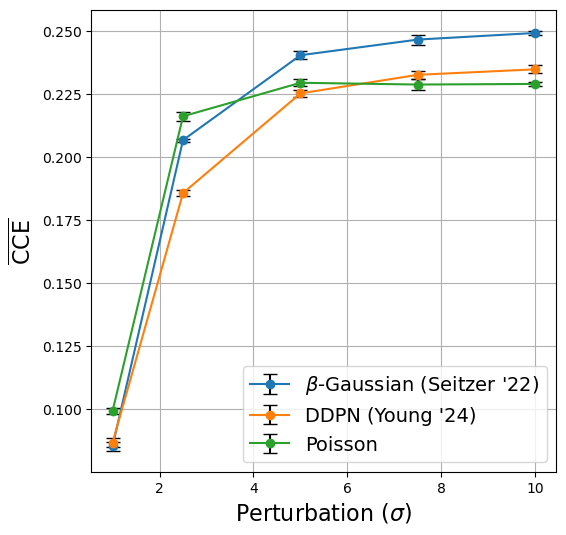

In [19]:
get_ood_fig(blur, 'ood_blur.pdf', append_xlabel=" ($\sigma$)")

<Figure size 640x480 with 0 Axes>

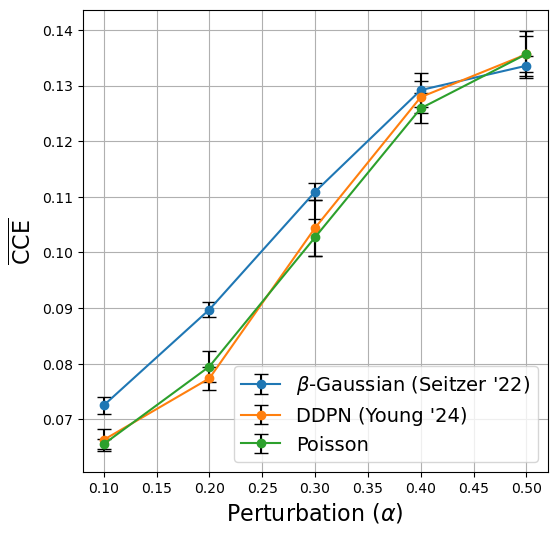

In [20]:
get_ood_fig(mixup, 'ood_mixup.pdf', append_xlabel=r' ($\alpha$)')

<Figure size 640x480 with 0 Axes>

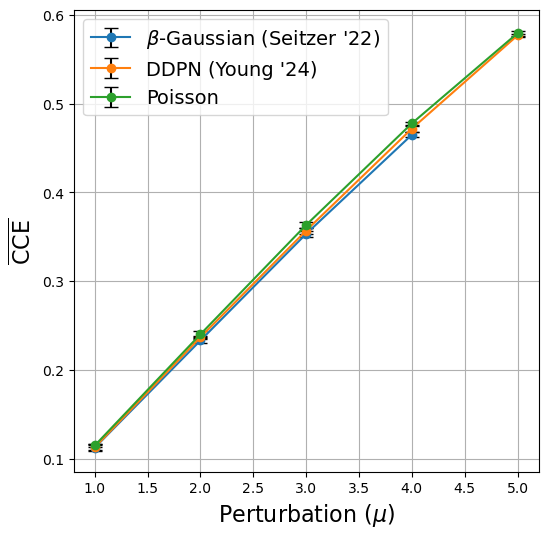

In [21]:
get_ood_fig(labelnoise, 'ood_labelnoise.pdf', append_xlabel=" ($\mu$)")

In [22]:
labelnoise

experiment                            head lambda perturb      mcmd  \
                                                                   mean   
42  labelnoise                DDPN (Young '24)   0.05     1.0  0.112943   
43  labelnoise                DDPN (Young '24)   0.05     2.0  0.236953   
44  labelnoise                DDPN (Young '24)   0.05     3.0  0.357063   
45  labelnoise                DDPN (Young '24)   0.05     4.0  0.471871   
46  labelnoise                DDPN (Young '24)   0.05     5.0  0.576913   
47  labelnoise                         Poisson   0.05     1.0  0.114959   
48  labelnoise                         Poisson   0.05     2.0  0.240273   
49  labelnoise                         Poisson   0.05     3.0  0.363378   
50  labelnoise                         Poisson   0.05     4.0  0.477793   
51  labelnoise                         Poisson   0.05     5.0  0.579423   
52  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     1.0  0.112530   
53  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     2.0  0.233290   
54  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     3.0  0.353374   
55  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     4.0  0.464963   

                    
         std count  
42  0.003105     5  
43  0.001620     5  
44  0.003424     5  
45  0.003441     5  
46  0.002121     5  
47  0.002160    10  
48  0.003663    10  
49  0.003009    10  
50  0.002112    10  
51  0.002750    10  
52  0.003492     5  
53  0.002740     5  
54  0.003368     5  
55  0.002959    10